In [1]:
%load_ext lab_black

# respyabc

--- 
Project for the course in Scientific Computing | Winter 2020/2021, M.Sc. Economics, Bonn University | [Manuel Huth](https://github.com/manuhuth)
 
---

In this notebook I use the *pyabc* package to estimate the model from *Keane and Wolpin* 1994 using the *respy* package.

> Emmanuel Klinger, Dennis Rickert, Jan Hasenauer (2018); pyABC: distributed, likelihood-free inference. Bioinformatics.

> Janos Gabler, Tobias Raabe (2020); respy - A framework for the simulation and estimation of Eckstein-Keane-Wolpin models.

#### Using respyabc

* Clone from [GitHub](https://github.com/manuhuth/respyabc) or install via [conda](https://conda.anaconda.org/manuhuth)
---

Loading all modules and functions is simply done by

In [2]:
import respy as rp
import numpy as np

import time

from pyabc.visualization import plot_kde_matrix_highlevel
from pyabc.visualization import plot_model_probabilities
from respyabc.distances import compute_mean_squared_distance
from respyabc.evaluation import compute_point_estimate
from respyabc.evaluation import plot_2d_histogram
from respyabc.evaluation import plot_history_summary
from respyabc.evaluation import plot_history_summary_no_kde
from respyabc.evaluation import plot_kernel_density_posterior
from respyabc.evaluation import plot_multiple_credible_intervals
from respyabc.models import compute_model
from respyabc.respyabc import respyabc
from respyabc.tools import convert_time
from respyabc.tools import plot_normal_densities

---
# 1 From respy and pyABC to respyabc
---

In this notebook I showcase the Python package respyabc, which offers a likelihood-free inference procedure for finite-horizon discrete choice models. The heart of respyabc are the two open-source packages respy (Gabler and Raabe; [2020](https://respy.readthedocs.io/en/latest/)) and pyABC (Klinger et al.; [2018](https://watermark.silverchair.com/bty361.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAr0wggK5BgkqhkiG9w0BBwagggKqMIICpgIBADCCAp8GCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM6WLi_HWh7fPxGjBoAgEQgIICcGn-J3-8gZEH93eB8Gphm7F3wCf9ux_fLjnoFR3ijbt06MKMNS0LPjKjApel0G5Ke2uZjYPBFRwC-aTWVQRLYNB2xpCRbHOzyPfYQrtoYlpmuHxy-JFAzxbwmv7DdOytmVwVyq6qGnx6Xzxls9nvdFdon1MPsCZ0Mj-x_Li6el_oGv0Eq9rY6Sd4QTicRuNCQ7Ci9GkXjDaSQR64hASP-dbUQjJUwlPsPTwUvGW8vTcHLP9LMj0gBaXvD3XM9MB0XtkNfGCBjxk1XmZV9bwJhD6FlI2AHfBGY3Avpusjjs3JPEL4HFt4DVVqhPWMD2TGgBGh9m62NDfV2-EH9bLc1XnTcWXk1FduyrNxomUmAsDgoSFAIndmVK2SS-wJC49iy1FnoCYt5l2XgLstI-0w9xcKNfMOks912e_S1rI1v012rgLydcybeyH--TcRl9tWjwKT_v4xwsTCMFpXnQqGOLa2HA93OuOpC9QHSmYaP2cp0a5Wq4seZArM28wYlF9D2nf0qjZRrlqqgLYXZmE_FEBStxiCeWMDYGq2t5A3w4buIqUsPepIQ70XJrwnIjUI8s0IAZUaQAqw2GRxtKLl-Q7qVj1YQnclN9E_LdioHe1_Er8KJoORZDARY_r1MWVn6o5TNWtgZhLyb-aoUbHnjgipUcZiXy-9NNZ122WcG4nVrms9eWQ5RC4boNdaEsBXxRKmuJUhtvgJswgrN9rUeidye7Ppqy13cD_LZwkYlDmKX9MAUnFj37X2kKtol1X84i3L_djRk2D20LhrDht9W4XwL5OK4SsEwRh_7GO8xP7hN57fttzHbMaV-qjg2K40EQ)]. We structured the notebook in the following way. First we review the relevant theory that is needed to understand the presented work. Second, we showcase how single parameter inference can be conducted by varying over the discount factor and using the activity's choice frquencies $a$ as well as the wage moments $w$ as summary statistics. Subsequently, we conduct inference for the two constants $\alpha_1, \alpha_2$ of the work equations $R_1$ and $R_2$ and afterwards for all non-zero equation parameters of the work equations. Before concluding, we show how respyabc can be used for model selection. We aim to explain all functionalities of respyabc within the analysis by giving code examples and explanations.  

**Model**\
respy is used to specify and simulate models. Currently, the first parameterization of the Keane and Wolpin [1994](https://www.jstor.org/stable/2109768?seq=1#metadata_info_tab_contents) model, which we abbreviate from here on with KW94, is the default standard. The incorporation of further and custom models is planned for the next release. We briefly sketch the KW94 model in this notebook to make the notebook self contained. A broader description of the model is given within their [paper](https://www.jstor.org/stable/2109768?seq=1#metadata_info_tab_contents).

Let $\tau \in \{0, \dotsc, T \}$ be a finite number of periods in which an individual $i \in I$ decides between working in occupation A ($a=1$) or B ($a=2$), schooling ($a=3$) and staying at home ($a=4$). For each decision an individual receives a choice-specific reward $R_a$ with

\begin{align}
R_1(\tau) &= w_{1\tau}=\exp{\left(\alpha_1 + \beta_{11} h_\tau + \gamma_{11} k_{1\tau} + \gamma_{12} k_{1\tau}^2 +  \gamma_{17} k_{2\tau} +  \gamma_{18} k_{2\tau}^2 + \varepsilon_{1\tau}  \right)} \\
R_2(\tau) &= w_{2\tau} = \exp{\left(\alpha_2 + \beta_{21} h_\tau + \gamma_{21} k_{2\tau} + \gamma_{22} k_{2\tau}^2 +  \gamma_{27} k_{1\tau} + \gamma_{28} k_{1\tau}^2 + \varepsilon_{2\tau}  \right)} \\
R_3(\tau) &= \alpha_3 + \beta_{\tau c} \mathbb{I}(h_\tau \geq 12) + \beta_{rc}[1-\mathbb{I}(a_{\tau-1} = 3)] + \varepsilon_{3\tau} \\
R_4(\tau) &= \alpha_4 + \varepsilon_{4\tau}.
\end{align}

$h_\tau$ denotes the years of schooling in period $\tau$ and $k_{a'\tau}$ denotes the work experience in occupation $a' \in \{1,2\}$. Using squared terms within the exponential function of $R_1(\tau)$ and $R_2(\tau)$ allows for a parabola shape of work experience on logarithmic rewards following the popular Mincer [1974](https://eric.ed.gov/?id=ED103621) equation. $w_{a'\tau}$ are wages that individuals earn from working in one of the two occupations that are equal to the respective rewards, excluding *after-work rewards*.

$\mathbb{I}(h_\tau \geq 12)$ is an indicator function that indicates if an individual has 12 or more years of schooling experience. $\beta_{a'1}, \beta_{a'2}, \gamma_{a'1}, \gamma_{a'2}, \gamma_{a'7}$ and $\gamma_{a'8}$ are coefficients to determine the influence of years of schooling and working on the rewards of occupation. $\beta_{\tau c}$ is the coefficent of having 12 or more years of schooling and $\beta_{rc}$ is the reward of going back to school after at least one year of abscence. $\mathbb{I}(a_{\tau} = 3)$ is a dummy that is one if the individual attended school in period $\tau$.
$\alpha_a$ are choice specific reward constants. $\varepsilon_{a\tau}$ are random shocks that can be correlated within a period $t$ and are a-priori  unknown to the individual.\
The optimizatzion problem that the forward-looking individual has to solve in any period $\tau$ is to maximize the expected sum of all discounted period utilities from period $\tau$ to period $T$. 

\begin{align}
v_\tau(s_\tau) = \mathbb{E} \left[\sum_{j=0}^{T-\tau} \delta^j u_{\tau+j}\left[s_{\tau+j}, a_{\tau+j}(s_{\tau+j})\right] \mid s_\tau  \right], 
\end{align}
where $s_\tau$ is the given state in period $\tau$ and $\delta \in (0,1]$ the discount factor. Using respy this optimization problem can be solved applying the principle of optimality from Bellmann ([1952](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1063639/)). With respy the user can calibarate her model by using empirical or simulated data of independent individuals via maximum likelihood estimation and estimation via the method of simulated moments. 
respyabc offers a likelihood-free alternative via approximate Bayesian computing (ABC) using a sequential Monte-Carlo (SMC) scheme. This is implemented by using pyABC. To go into more detail of pyABC we first introduce some notation and define summary statistics for observed/simulated data that we use within the analysis.

**Data summary statistics**\
Let $Y^{(q)} \in \mathbb{R}^{(T+1) \times |I|}$ be the matrix collecting the observed/simulated outcome of interest $q$ for each individual $i \in I$ at all periods $\tau \in \{0, \dotsc, T \}$. Precisely, $y^{(q)}_{\tau i}$ is the entry in row $\tau$ and column $i$ of $Y^{(q)}$ and represents the outcome of interest $q$ for individual $i$ in period $\tau$. In our application, the outcome of interest are either the wages $w$ or the choices $a$, such that $q \in \{w, a \}$.
Let $s^{(q)}$ be a function that transforms the population data into chosen summary statistics $S^{(q)} = s^{(q)}(Y^{(q)})$, with $S^{(q)} \in \mathbb{R}^{(T+1) \times \zeta^{(q)}}$ being a matrix containing $\zeta^{(q)}$ summary statistics of the population, measured at each period $\tau$.\
$s^{(a)}(Y^{(a)})$ is defined to be the function that returns the choice frequencies of any alternative $a \in \{1,2,3,4\}$ for each period $\tau$. Thus, $\zeta^{(a)} = 4$ and the $\tau$-th row of $S^{(a)}$ is defined as 
\begin{align}
\frac{1}{|I|}  \begin{pmatrix} \sum_{i = 1}^{|I|} \mathbb{I}(y^{(a)}_{\tau i} = 1) & \sum_{i = 1}^{|I|} \mathbb{I}(y^{(a)}_{\tau i} = 2) & \sum_{i = 1}^{|I|} \mathbb{I}(y^{(a)}_{\tau i} = 3) & \sum_{i = 1}^{|I|} \mathbb{I}(y^{(a)}_{\tau i} = 4) \end{pmatrix}'.
\end{align}
Analogously, $s^{(w)}(Y^{(w)})$ is defined to be the function that returns the row means and row standard deviations of $Y^{(w)}$ as columns, such that the $\tau$-th row of $S^{(w)}$ is defined as
\begin{align}
\begin{pmatrix} \overline{y}^{(w)}_{\tau} & \frac{1}{|I|-1} \sum_{i = 1}^{|I|} \left(y^{(a)}_{\tau i} - \overline{y}^{(w)}_{\tau} \right)  \end{pmatrix}',
\end{align}
where $\overline{y}^{(w)}_{\tau}=\frac{1}{|I|}  \sum_{i = 1}^{|I|} y^{(w)}_{\tau i}$
Thus, $\zeta^{(w)} = 2$. 

**pyABC**\
We can see one simulation of the KW94 model with a subsequent computation of the summary statistics as a mapping $\mathcal{M}^{(q)}$ from a $d$- dimensional input vector $\theta \in \Theta \subset \mathbb{R}^n$, with parameter space $\Theta$, to summary statistics of the simulated data 
\begin{align}
S^{(q)} = s^{(q)}(Y^{(q)}) =\mathcal{M}^{(q)}(\theta). 
\end{align}
$\theta$ consists in general of (some of) the $\alpha, \beta$ and $\gamma$ coefficients presented above. Additionally, the correlations and standard deviations of the period specific disturbances $\varepsilon_{at}$ and the discount factor can be seen as parameters within $\theta$. In this notebook we subsequently increase the number of parameters to analyze and finally conduct analysis for all non-zero parameters of the KW94 model. 

For inference purposes we are interested in the likelihood of a parameter vector given observed data $Y^{(q)}$. This likelihood is reflected by the *posterior distribution* $p(\theta|Y^{(q)})$. We can describe the posterior distribution in terms of the *likelihood* $f(Y^{(q)}| \theta)$ and the *prior distribution* $\pi(\theta)$
\begin{align}
    p(\theta|Y^{(q)}) = \frac{f(Y^{(q)}| \theta) \pi(\theta) }{\int f(Y^{(q)}| \theta') \pi(\theta') d\theta'} \propto f(Y^{(q)}| \theta) \pi(\theta) .
\end{align}

For complicated $\mathcal{M}^{(q)}$ the posterior might not be traceable at all. In these cases we can use ABC to estimate parameters likelihood-free. The idea is to sample parameters $\theta$ such that the simulated model output $\hat{Y}^{(q)}$ is *close* to the observed data $Y^{(q)}$. For computational convenience, we do not use the data of $Y^{(q)}$ and $\hat{Y}^{(q)}$ but their summary statistics $S^{(q)}$ and $\hat{S}^{(q)}$ instead. For individuals in the sense of the KW94 model their order in the population, e.g. which individual is placed in which column of $Y^{(q)}$, is redundant and we need to use a 'sample location' which is invariant to the ordering. This is the case for our summary statistics $a$ and $w$ since they are computed using first and second moments.  

To define what being *close* means for two matrices of summary statistics we need to define a suitable distance $d^{(q)}:\mathbb{R}^{(T+1) \times \zeta^{(q)}} \times \mathbb{R}^{(T+1) \times \zeta^{(q)}} \to \mathbb{R_+}$. In our application, we use the averaged squared Frobenius-Norm of the differences between both matrices, which is just the mean of the squarred differences in each cell of the summary matrices. A simulated output $\hat{Y}_j^{(q)}$ is defined to be close to $Y^{(q)}$ if $d(S^{(q)}, \hat{S}_j^{(q)}) < \epsilon$ for a fixed small $\epsilon > 0$.

\begin{align}
    p(\theta|S^{(q)}) = \frac{f(S^{(q)}| \theta) \pi(\theta) }{p(S^{(q)})} \approx \frac{\int  f(S| \theta) \pi(\theta) \mathbb{I}\left[d(S^{(q)},S) < \epsilon \right] dS}{p(S^{(q)})} = p_\epsilon(\theta|S^{(q)}),
\end{align}
such that $\lim\limits_{\epsilon \to 0} p_\epsilon(\theta|S^{(q)}) = p(\theta|S^{(q)})$. 

In the abc-smc algorithm we simulate whole populations of simulated parameters $\{\hat{\theta}_{tj}^{(q)}\}_{j=0, \dotsc, p_t}$ for a fixed $t=0,1, \dotsc, n$, where $t$ indicates the simulation iteration and $j$ indicates the $j$-th simulated accepted data sample, to approximate the true parameters. Note that the population size $p_t$ has a subscript $t$, since it usually varies over the iterations. You can find a note on that in Klinger et al. [2018](https://watermark.silverchair.com/bty361.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAr0wggK5BgkqhkiG9w0BBwagggKqMIICpgIBADCCAp8GCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM6WLi_HWh7fPxGjBoAgEQgIICcGn-J3-8gZEH93eB8Gphm7F3wCf9ux_fLjnoFR3ijbt06MKMNS0LPjKjApel0G5Ke2uZjYPBFRwC-aTWVQRLYNB2xpCRbHOzyPfYQrtoYlpmuHxy-JFAzxbwmv7DdOytmVwVyq6qGnx6Xzxls9nvdFdon1MPsCZ0Mj-x_Li6el_oGv0Eq9rY6Sd4QTicRuNCQ7Ci9GkXjDaSQR64hASP-dbUQjJUwlPsPTwUvGW8vTcHLP9LMj0gBaXvD3XM9MB0XtkNfGCBjxk1XmZV9bwJhD6FlI2AHfBGY3Avpusjjs3JPEL4HFt4DVVqhPWMD2TGgBGh9m62NDfV2-EH9bLc1XnTcWXk1FduyrNxomUmAsDgoSFAIndmVK2SS-wJC49iy1FnoCYt5l2XgLstI-0w9xcKNfMOks912e_S1rI1v012rgLydcybeyH--TcRl9tWjwKT_v4xwsTCMFpXnQqGOLa2HA93OuOpC9QHSmYaP2cp0a5Wq4seZArM28wYlF9D2nf0qjZRrlqqgLYXZmE_FEBStxiCeWMDYGq2t5A3w4buIqUsPepIQ70XJrwnIjUI8s0IAZUaQAqw2GRxtKLl-Q7qVj1YQnclN9E_LdioHe1_Er8KJoORZDARY_r1MWVn6o5TNWtgZhLyb-aoUbHnjgipUcZiXy-9NNZ122WcG4nVrms9eWQ5RC4boNdaEsBXxRKmuJUhtvgJswgrN9rUeidye7Ppqy13cD_LZwkYlDmKX9MAUnFj37X2kKtol1X84i3L_djRk2D20LhrDht9W4XwL5OK4SsEwRh_7GO8xP7hN57fttzHbMaV-qjg2K40EQ).\
The iterative ABC-SMC procedure works as follows (Toni et al.; [2008](https://royalsocietypublishing.org/doi/10.1098/rsif.2008.0172))

1. Initialize run. \
    1.1 Draw candidates $\hat{\theta}_{0j}$ unconditionally from the prior distribution $\pi(\theta)$ and accept if $d^{(q)}\left(\hat{S}_{0j}^{(q)}, S^{(q)}\right) < \epsilon_0$. Repeat until $p_0$ simulations have been accepted and set them as initial population $\hat{\theta}_0 = \left\{\hat{\theta}_{01}^{(q)}, \dotsc, \hat{\theta}_{0p_0}^{(q)} \right\}$.\
    1.2 Set weights $\omega_{0j} = 1/p_0$ 
2. Set $\epsilon_1$ to the median distance of the previous population.\
    2.1 Sample $\hat{\theta}_{1j}$ from $\hat{\theta}_0$ with weights $\omega_0$ and perturb it with a perturbation kernel $K_1$ (see Toni et al. ([2008](https://royalsocietypublishing.org/doi/10.1098/rsif.2008.0172))). Accept if $d^{(q)}\left(\hat{S}_{1j}^{(q)}, S^{(q)}\right) < \epsilon_1$. Repeat until $p_1$ simulations have been accepted and set them as population $\hat{\theta}_1 = \left\{\hat{\theta}_{11}^{(q)}, \dotsc, \hat{\theta}_{1p_1}^{(q)} \right\}$.\
    2.2 Set weights to $\omega'_{1j} = \frac{\pi(\theta_{1j})}{\sum_{j=1}^{p_1} \omega_{0j} K_1\left(\theta_{1j}, \theta_{0j}\right)}$ and normalize them such that their sum equals one to obtain $\omega_{1j}$.
3. Proceed with the same procedure until the $n$-th population $\hat{\theta}_n = \left\{\hat{\theta}_{n1}^{(q)}, \dotsc, \hat{\theta}_{np_n}^{(q)} \right\}$ is simulated using $\epsilon_n$.

In respyabc the user needs to define $\epsilon_n$, which is to say, the minimum epsilon and therefore the acceptance threshold. The acceptance rate is off course very sensitive to the choice of $\epsilon_n$. On the one hand, if $\epsilon_n$ is too large the approximation error is too high and we tend to accept samples generated by parameters that are far away from the true ones. On the other hand, if $\epsilon_n$ is too small, we might decline too many samples and the algorithm has a hard time computing estimates. 

## KW94model settings

We use respy to load the settings of the KW94 model and inspect the true parameter we will use to get on overview of the magnitudes we vary over. If desired, the user can use ``params`` to get a glimpse on how the parameters look like. For readability, we refrain from showing the parameters in `params` in the standard notebook.

In [3]:
params, options, data_stored = rp.get_example_model("kw_94_one")

To run respyabc efficiently, it is necessary that the distance $d^{(q)}(\cdot)$ we observe is (close to) zero if we simualte the model with the true parameter vector $\theta$. Hence, we want that $\mathcal{M}^{(q)}(\theta)=S^{(q)}$ is invariant to the choice of the random simulation seed. We achieve this in the KW94 setting by choosing a suitable large number of individuals and decision periods, such that the summary statistics are invariant to the seeds. We keep the standards of $T=40$ simulated periods and $|I|=1000$ individuals for each run of the KW94 model.

In [4]:
periods = options["n_periods"]
agents = options["simulation_agents"]
f"The KW94 model consists of {periods} periods and {agents} agents."

'The KW94 model consists of 40 periods and 1000 agents.'

---
# 2 Inference
---

## 2.1 Single parameter

In this subsecton we vary over the discount factor delta, which is in the KW94 model set to $\delta = 0.95$ such that the model of interest becomes $\mathcal{M}^{(q)}(\delta)=S^{(q)}$. We compare how respyabc performs for both types of summary statistics $q=a,w$.

To simulate the true population in respyabc we need to define the model that is to be simulated and choose between $d^{(a)}(\cdot)$ and $d^{(w)}(\cdot)$ to compute the distance between 2 populations. Naming the parameter `delta_delta` seems to be unnecassarily cumbersome in the first place. However, note that `params` is a multi-indexed data frame but pyABC only works with single-indexed data frames. Thus, respyabc melts both indices to an index and divides them by an underscore, such that the parameter key and the data frame index can be called within one string but the parameter is still uniquely identified in `params`. The parameters are, according to pyABC, defined in a dictionary. Note that we do not need to pass the parameter of inetrest here as additional argument for simulating the data since we use the default value that is already in ``params``. We do so, however, to showcase the user how changing the  reference data set can be done. 

In [5]:
model_to_simulate = rp.get_simulate_func(params, options)
parameter_true_single_delta_a = {"delta_delta": 0.95}

### 2.1.1 Using choice frequencies

In this first example we use $q=a$. We can pass this to respyabc by specifying `descriptives="choice_frequencies"`. Moreover, respyabc allows to modify the parameter values over which we do not vary and the custom options. Note that settings in `parameter_for_simulation` are overwritten by setting the true parameter through the dictionary. We distinguish between varying and fixed parameters since the function `compute_model` is used within the ABC_SMC scheme. We set the parameters and options of the model to the to their default values by spassing `parameter_for_simulation=params` and `options_for_simulation=options` to the function.

**Setting up the data**

In [6]:
np.random.seed(12)
pseudo_observed_data_a = compute_model(
    parameter_true_single_delta_a,
    model_to_simulate=model_to_simulate,
    parameter_for_simulation=params,
    options_for_simulation=options,
    descriptives="choice_frequencies",
)

To varify that $\mathcal{M}^{(q)}(\delta)$ is invariant to the seed random seed, we run the simulation again using a different seed.

In [7]:
np.random.seed(123)
pseudo_observed_data_a_test = compute_model(
    parameter_true_single_delta_a,
    model_to_simulate=model_to_simulate,
    parameter_for_simulation=params,
    options_for_simulation=options,
    descriptives="choice_frequencies",
)

We can compare two distances by using the mean squared difference between both matrices of summary statistics.

In [8]:
seed_distance_a = compute_mean_squared_distance(
    pseudo_observed_data_a_test, pseudo_observed_data_a
)
f"The distance is: {seed_distance_a :0.2f}"

'The distance is: 0.00'

**Choosing the pyABC settings**\
We set the size of the pyABC samples to 500 and the maximum possible number of drawn populations to $n=10$. The excact magnitudes in applications depend on the respective data. In general, if a rigorous analysis is desired, the maximum number of drawn pyABC populations should not be reached, since this tool is more for convenience to reduce computation time and give the user the possibility to check the results.

In [9]:
population_size = 2
max_nr_populations = 2

$\epsilon_n$ is set to be 0.05. This was found to be a valid epsilon in previous simulations. We choose a uniform prior $\delta \sim U(\cdot)$. Choosing a uniform prior has the advantage that the user sets the distribution bounds as bounds for the posterior distribution, yielding more control on which values to allow. Specifying priors must be done in a dictionary with the parameter name corresponding to the multiindex of `params` as key and a list containing another list that specifies the distribution parameters and the type of the distribution. Currently only the uniform distribution (`"uniform"`) and the normal distribution (`"norm"`) are implemented.

In [10]:
minimum_epsilon = 0.05
delta_prior_low_single_delta_a = 0.9
delta_prior_length_single_delta_a = 0.09
parameters_prior_single_delta_a = {
    "delta_delta": [
        [delta_prior_low_single_delta_a, delta_prior_length_single_delta_a],
        "uniform",
    ]
}

`"delta_delta"` is the key identifier, `delta_prior_low_single_delta_a` is the lower bound of the uniform distribution and `delta_prior_length_single_delta_a` is the length of the uniform interval and **not** the upper bound. We chose this type setting of the uniform distribution in order to be in line with `pyABC`, which follows `scipy`.  

After specifying all relevant parameters, inference is conducted by using the `respyabc` function. To run the fucntion we need to specify model $\mathcal{M}^{(q)}$ by `model`, define the prior distribution $\pi(\delta)$ by `parameters_prior`, the true data $S^{(q)}$ by `data`, the distance measure $d^{(q)}$ by `compute_mean_squared_distance`, the type of descriptive statistics $q$ by `descriptives`, the first population size $p_0$ by `population_size_abc`, the maximum number of populations by `max_nr_populations_abc` and $\epsilon_n$ by `minimum_epsilon_abc`.

We keep track of the simulation time to give a glimpse on how long simulation times are.

In [11]:
np.random.seed(1234)
start_single_delta_a = time.perf_counter()
history_single_delta_a = respyabc(
    model=compute_model,
    parameters_prior=parameters_prior_single_delta_a,
    data=pseudo_observed_data_a,
    distance_abc=compute_mean_squared_distance,
    descriptives="choice_frequencies",
    population_size_abc=population_size,
    max_nr_populations_abc=max_nr_populations,
    minimum_epsilon_abc=minimum_epsilon,
)
end_single_delta_a = time.perf_counter()

In [12]:
time_single_delta_a, unit_single_delta_a = convert_time(
    end_single_delta_a - start_single_delta_a
)
f"The respyabc run took {time_single_delta_a:0.2f} {unit_single_delta_a}"

'The respyabc run took 30.77 seconds'

**Evaluation**\
To evaluate how accurately we have estimated $\delta$ we use a point estimate, kernel densitie estimates, credible intervals and take a visual look at the convergence of the ABC-SMC scheme by inspecting acceptance rates and the trajectory of $\epsilon_i$.\
We compute a point estimate as weighted average $\sum_{j=1}^{p_n} \omega_{nj} \hat{\theta}_{nj}^{(a)}$ of the $n$-th population. This can be done using respyabc's `compute_point_estimate` function by simply passing the created history object `history_single_delta_a`.

In [13]:
estimate_single_delta_a = compute_point_estimate(history_single_delta_a).loc[
    "estimate", "delta_delta"
]
f"The point estimate for delta is: {estimate_single_delta_a:0.4f}"

'The point estimate for delta is: 0.9584'

The point estimate is already very accurate. To become a better understanding on how the prior distribution looks like and evolves over $t$, we plot kernel density estimates using normal kernels. This can be done by simply passing the created history object, the parameter name and the desired bounds of the axes to the respyabc function `plot_kernel_density_posterior`.

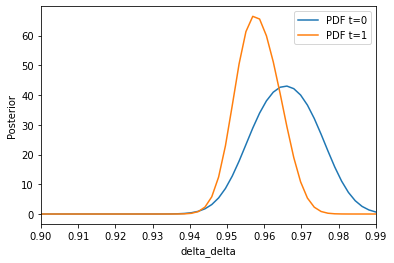

In [14]:
xmax_single_delta_a = delta_prior_low_single_delta_a + delta_prior_length_single_delta_a
plot_kernel_density_posterior(
    history=history_single_delta_a,
    parameter="delta_delta",
    xmin=delta_prior_low_single_delta_a,
    xmax=xmax_single_delta_a,
)

We observe that the distributions center, as expected, with increasing $t$ and thus decreasing $\epsilon$. Since the function `respyabc` returns a [ABCSMC](https://pyabc.readthedocs.io/en/latest/api_inference.html) class, all model assessments tools from pyABC are feasible to apply as well. Hence, we can use the well implemented functions to track the evolution of $\epsilon_t$, the $p_t$ and plot credible intervals. respyabc offers a wrapper `plot_history_summary` for a fast implementation that only requires the history, parameter name and the reference value.\
The plot in the upper left corner depicts the credibility intervals at levels $0.5,0.9,0.95$. They can be interpreted as: Given the observed data, the intervals contain the true unknown parameter with the respective probability. The plot also shows how the point estimate (Mean) and the maximum value of the kernel density estimates evolve over $t$. The plot in the upper right depicts the trajectory of the epsilons. The plots in the second row depict the acceptance rates and the required samples that were needed to reach the desired sample size $p_t$.

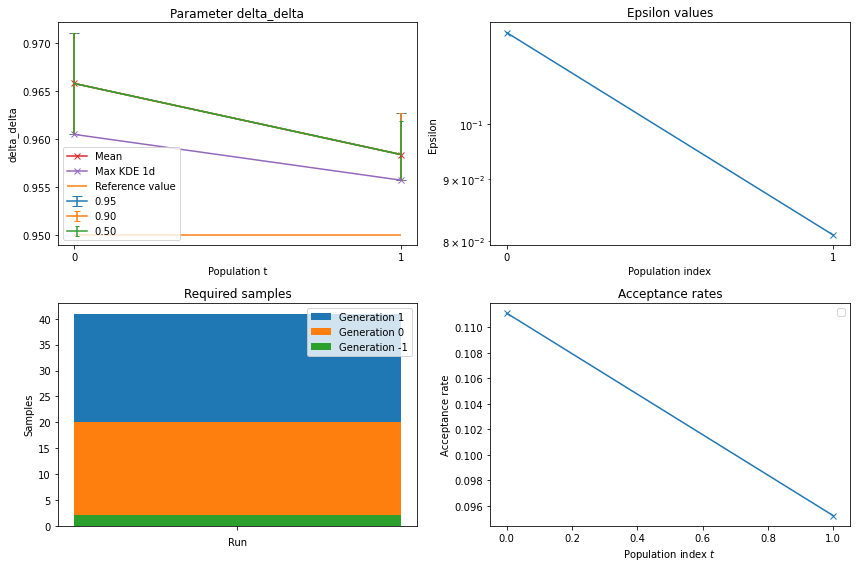

In [15]:
plot_history_summary(
    history=history_single_delta_a, parameter_name="delta_delta", parameter_value=0.95
)

### 2.1.2 Using wage moments

In the next step, we conduct the same analysis varying over $\delta$ but choose $q=w$. To use the wage moments, we first need to compute the exemplary data set with the wage moments as summary statistics. We can do so by setting `descriptives="wage_moments"`. All other parameters are equal to the specififcation using $q=a$. We set the same seed to obtain the same data. As done in the previous analysis, we compare the distance for two seeds to see if the summary statistics are invariant to the choice of the seed.

In [16]:
np.random.seed(12)
pseudo_observed_data_single_delta_w = compute_model(
    parameter_true_single_delta_a,
    model_to_simulate=model_to_simulate,
    parameter_for_simulation=params,
    options_for_simulation=options,
    descriptives="wage_moments",
)
np.random.seed(123)
pseudo_observed_data_single_delta_w_test = compute_model(
    parameter_true_single_delta_a,
    model_to_simulate=model_to_simulate,
    parameter_for_simulation=params,
    options_for_simulation=options,
    descriptives="wage_moments",
)

In [17]:
seed_distance_single_delta_w = compute_mean_squared_distance(
    pseudo_observed_data_single_delta_w_test, pseudo_observed_data_single_delta_w
)
f"The distance is: {seed_distance_single_delta_w :0.2f}"

'The distance is: 0.00'

With regard to the previous analysis we only need to adjust the data by `data=pseudo_observed_data_single_delta_w` and the type of summary statistics by `descriptives="wage_moments"`. Moreover, since the magnitudes of the wage moments ar ehigher, we set $\epsilon_n=10^6$ which turned out to be a reasonable magnitude.

In [18]:
np.random.seed(1234)
start_single_delta_w = time.perf_counter()
history_single_delta_w = respyabc(
    model=compute_model,
    parameters_prior=parameters_prior_single_delta_a,
    data=pseudo_observed_data_single_delta_w,
    distance_abc=compute_mean_squared_distance,
    descriptives="wage_moments",
    population_size_abc=population_size,
    max_nr_populations_abc=max_nr_populations,
    minimum_epsilon_abc=10 ** 6,
)
end_single_delta_w = time.perf_counter()

In [19]:
time_single_delta_w, unit_single_delta_w = convert_time(
    end_single_delta_w - start_single_delta_w
)
f"The respyabc run took {time_single_delta_w:0.2f} {unit_single_delta_w}"

'The respyabc run took 31.64 seconds'

Computing the point estimate is done by using the weighted mean, analogously to the case where $q=a$. We observe that the estimate is exactly equal to the parameter and therefore even closer than the estimate using the choice frequencies. However, the for $q=w$ the algorithm has a larger $n$ and thus we could choose $\epsilon_n$ smaller for $q=a$ to see if this improves the estimate. Moreover, both estimates are very close and we recommend further analysis to determine which summary statistics perform better. 

In [20]:
estimate_single_delta_w = compute_point_estimate(history_single_delta_w).loc[
    "estimate", "delta_delta"
]
f"The point estimate for delta is: {estimate_single_delta_w:0.4f}"

'The point estimate for delta is: 0.9509'

We plot the same summary statistics as for the previous analysis. The kernel density estimates become again more and more centered around the true value for increasing $t$, indicating that the variance of the population decreases and the mean becomes equal to the true value. 

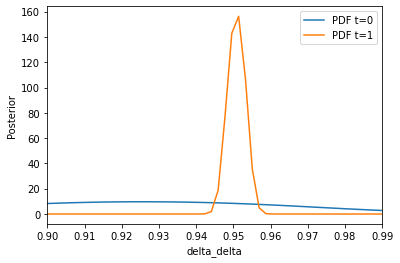

In [21]:
xmax_single_delta_a = delta_prior_low_single_delta_a + delta_prior_length_single_delta_a
plot_kernel_density_posterior(
    history=history_single_delta_w,
    parameter="delta_delta",
    xmin=delta_prior_low_single_delta_a,
    xmax=xmax_single_delta_a,
)

Further summary statistics underline our findings. The mean estimator is already at the second population very accurate and smoothes even closer to the true value for higher $t$. The trajectory of the epsilons and the acceptance rates look similar to the plots using the choice frequencies.

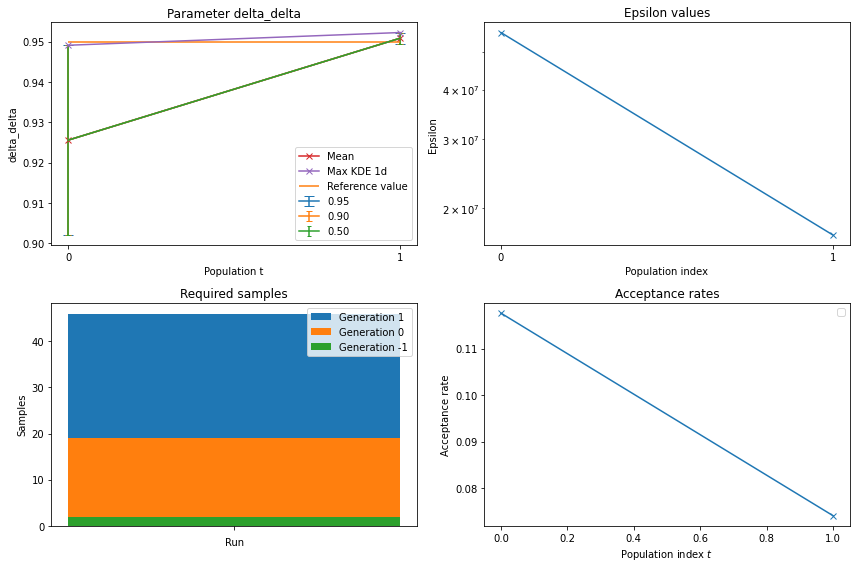

In [22]:
plot_history_summary(
    history=history_single_delta_w, parameter_name="delta_delta", parameter_value=0.95
)

## 2.2 Multiple parameters

In this subsection we extend the analysis and vary over multiple parameters. First, we use the wage constants such that $\theta = \begin{pmatrix} \alpha_1 & \alpha_2 \end{pmatrix}$ and second we use all non-zero parameters of the work equations. We only use choice frequencies as summary statistics in his chapter. Extensions can be done simultaneously to the single parameter case by changing the respective strings to "wage_moments". 

### 2.2.1 Two parameters

We first vary over two parameters to showcase the transition from a single parameter model to a multiple parameter model. Our parameters of choice are the constants $\alpha_1$ and $\alpha_2$ from equations $R_1$ and $R_2$ such that the model becomes $\mathcal{M}^a(\alpha_1, \alpha_2)$.\
As in the single parameter case, we need to define prior distributions. For multiple parameters, we can simply define them in one dictionary with the keys equal to the melted multiindex from the data frame `params` and the values equal to the desired magnitude.

In [23]:
parameters_prior_multi_alpha = {
    "wage_a_constant": [[9, 1], "uniform"],
    "wage_b_constant": [[8, 1], "uniform"],
}

Armed with the priors, running `respyabc` with multiple parameters is equivalent to the previous chapter.

In [24]:
np.random.seed(234)
start_multi_alpha = time.perf_counter()
history_multi_alpha = respyabc(
    model=compute_model,
    parameters_prior=parameters_prior_multi_alpha,
    data=pseudo_observed_data_a,
    distance_abc=compute_mean_squared_distance,
    descriptives="choice_frequencies",
    population_size_abc=population_size,
    max_nr_populations_abc=max_nr_populations,
    minimum_epsilon_abc=minimum_epsilon,
)
end_multi_alpha = time.perf_counter()

In [25]:
time_multi_alpha, unit_multi_alpha = convert_time(end_multi_alpha - start_multi_alpha)
f"The respyabc run took {time_multi_alpha:0.2f} {unit_multi_alpha}"

'The respyabc run took 33.28 seconds'

**describe estimates** 

In [26]:
estimate_multi_alpha = compute_point_estimate(history_multi_alpha).loc["estimate", :]
estimate_multi_alpha

name
wage_a_constant    9.418201
wage_b_constant    8.855216
Name: estimate, dtype: float64

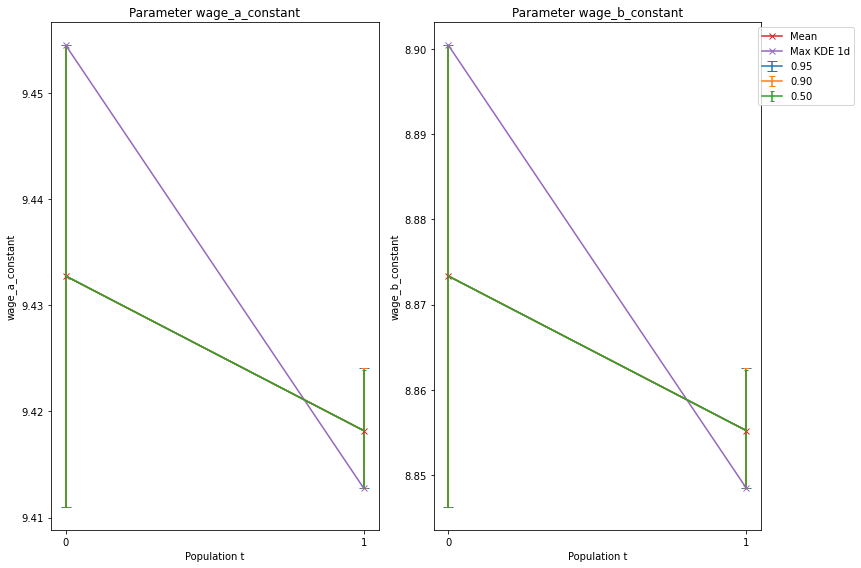

In [27]:
plot_multiple_credible_intervals(
    history=history_multi_alpha,
    number_rows=1,
    number_columns=2,
    parameter_names=["wage_a_constant", "wage_b_constant"],
)

/home/manuel/Documents/respyabc/respyabc/evaluation.py:462: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(3, ncol, t + 1)


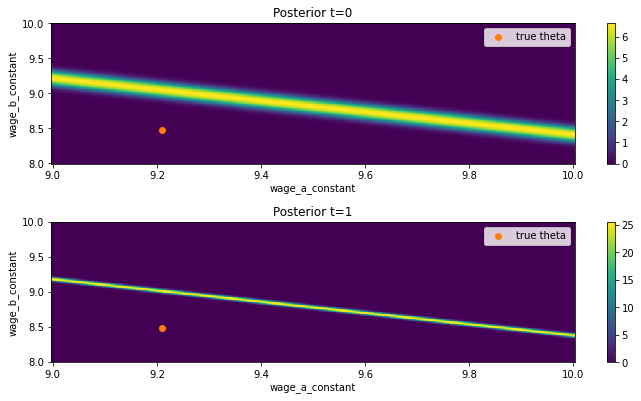

In [28]:
xmin = parameters_prior_multi_alpha["wage_a_constant"][0][0]
xmax = xmin + parameters_prior_multi_alpha["wage_a_constant"][0][1]
ymin = parameters_prior_multi_alpha["wage_b_constant"][0][0]
ymax = xmin + parameters_prior_multi_alpha["wage_b_constant"][0][1]

plot_2d_histogram(
    history=history_multi_alpha,
    parameter_names=["wage_a_constant", "wage_b_constant"],
    parameter_true=[9.21, 8.48],
    xmin=xmin,
    xmax=xmax,
    ymin=ymin,
    ymax=ymax,
)

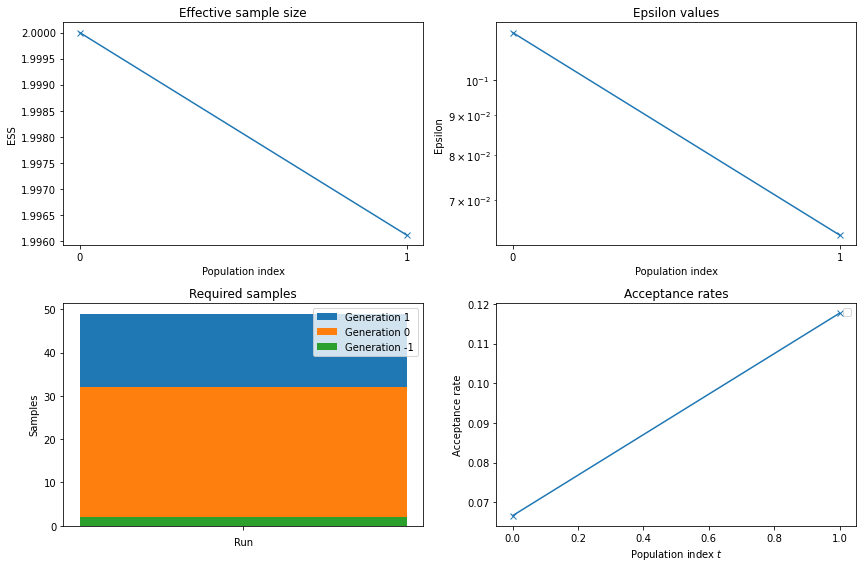

In [29]:
plot_history_summary_no_kde(history_multi_alpha)

**describe plots**

### 2.2.2 All non-zero parameters

- model
- kde matrix as in Multi-scale model: Tumor spheroid growth example

mathematically describe model (theta)

In [30]:
parameters_prior_multi = {
    "delta_delta": [
        [delta_prior_low_single_delta_a, delta_prior_length_single_delta_a],
        "uniform",
    ],
    "wage_a_constant": [
        [
            parameters_prior_multi_alpha["wage_a_constant"][0][0],
            parameters_prior_multi_alpha["wage_a_constant"][0][1],
        ],
        "uniform",
    ],
    "wage_a_exp_edu": [[0, 0.1], "uniform"],
    "wage_a_exp_a": [[0, 0.1], "uniform"],
    "wage_a_exp_a_square": [[-0.05, 0.05], "uniform"],
    "wage_b_constant": [
        [
            parameters_prior_multi_alpha["wage_b_constant"][0][0],
            parameters_prior_multi_alpha["wage_b_constant"][0][1],
        ],
        "uniform",
    ],
    "wage_b_exp_edu": [[0, 0.1], "uniform"],
    "wage_b_exp_b": [[0, 0.1], "uniform"],
    "wage_b_exp_b_square": [[-0.05, 0.05], "uniform"],
    "wage_b_exp_a": [[0, 0.1], "uniform"],
    "wage_b_exp_a_square": [[-0.05, 0.05], "uniform"],
}

In [31]:
np.random.seed(2345)
start_multi = time.perf_counter()
history_multi = respyabc(
    model=compute_model,
    parameters_prior=parameters_prior_multi,
    data=pseudo_observed_data_a,
    distance_abc=compute_mean_squared_distance,
    descriptives="choice_frequencies",
    population_size_abc=population_size,
    max_nr_populations_abc=max_nr_populations,
    minimum_epsilon_abc=minimum_epsilon,
)
end_multi = time.perf_counter()

In [32]:
time_multi, unit_multi = convert_time(end_multi - start_multi)
f"The respyabc run for delta using choice frequencies took {time_multi:0.2f} {unit_multi}"

'The respyabc run for delta using choice frequencies took 1.10 minutes'

In [33]:
estimate_multi = compute_point_estimate(history_multi).loc["estimate", :]
estimate_multi

name
delta_delta            0.981796
wage_a_constant        9.196341
wage_a_exp_a           0.018987
wage_a_exp_a_square   -0.007711
wage_a_exp_edu         0.013033
wage_b_constant        8.960671
wage_b_exp_a           0.030053
wage_b_exp_a_square   -0.012232
wage_b_exp_b           0.063055
wage_b_exp_b_square   -0.003184
wage_b_exp_edu         0.071396
Name: estimate, dtype: float64

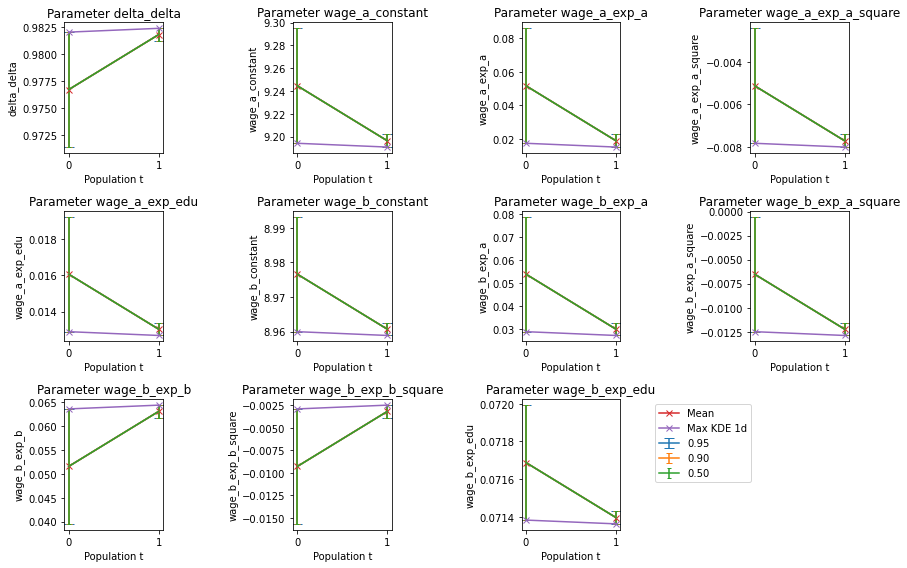

In [34]:
par_names = estimate_multi.index
plot_multiple_credible_intervals(
    history=history_multi,
    parameter_names=par_names,
    number_rows=3,
    number_columns=4,
    delete_axes=[2, 3],
    legend_location="lower_right",
)

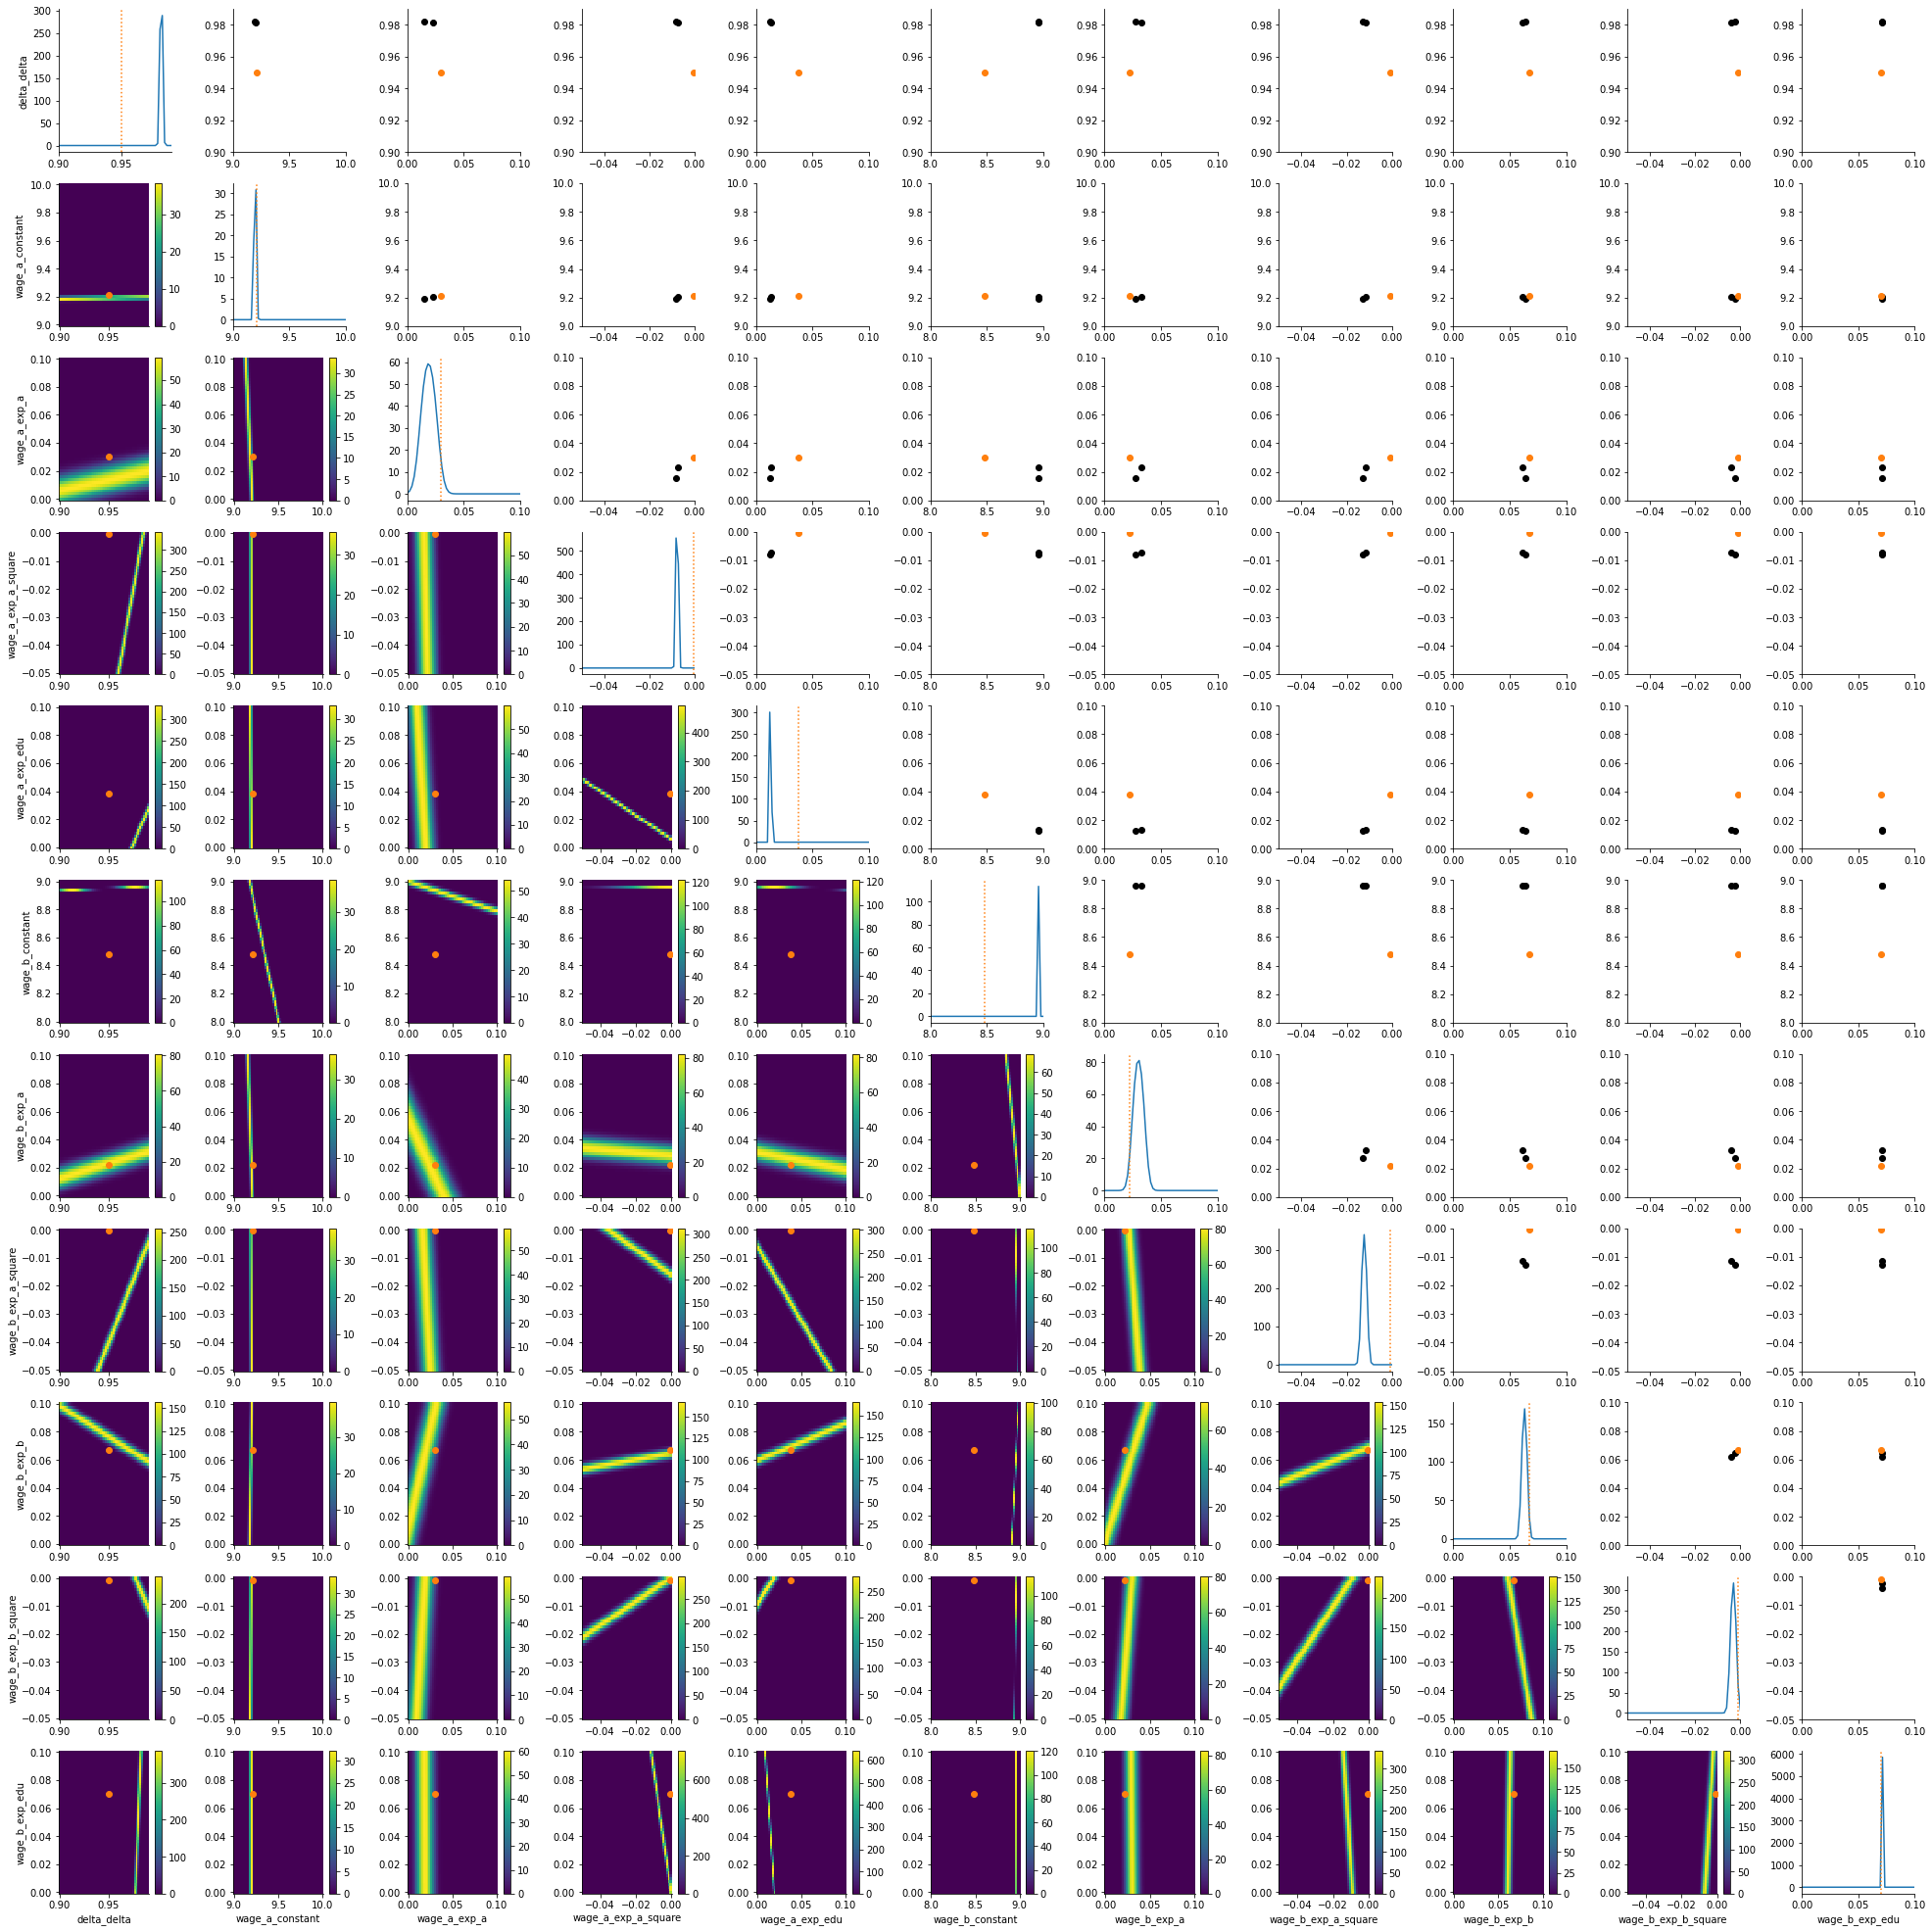

In [35]:
true_values = {
    "delta_delta": 0.95,
    "wage_a_constant": 9.21,
    "wage_a_exp_a": 0.03,
    "wage_a_exp_a_square": -0.0005,
    "wage_a_exp_edu": 0.038,
    "wage_b_constant": 8.48,
    "wage_b_exp_a": 0.0220,
    "wage_b_exp_a_square": -0.0005,
    "wage_b_exp_b": 0.0670,
    "wage_b_exp_b_square": -0.001,
    "wage_b_exp_edu": 0.07,
}
limits = {}
keys = parameters_prior_multi.keys()
for i in keys:
    limits[i] = (
        parameters_prior_multi[i][0][0],
        parameters_prior_multi[i][0][0] + parameters_prior_multi[i][0][1],
    )
kde_matrix = plot_kde_matrix_highlevel(history_multi, refval=true_values, limits=limits)

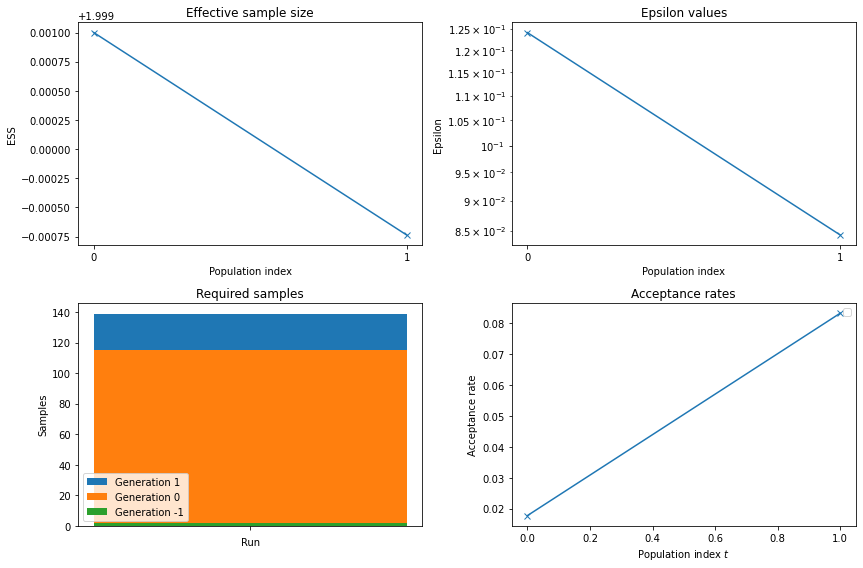

In [36]:
plot_history_summary_no_kde(history_multi)

# 3 Model selection
---

- compare model with one parameter and normal prior
- mention that this just a brief introduction. add section on that to theory part

In [37]:
models = [compute_model, compute_model]
parameter_selection = "wage_a_exp_edu"
mu1 = params.loc["wage_a", "exp_edu"][0] * 1
var1 = 0.004
mu2 = params.loc["wage_a", "exp_edu"][0] * 0.6
var2 = 0.004
parameter_prior_selection_model1 = {parameter_selection: [[mu1, var1], "norm"]}
parameter_prior_selection_model2 = {parameter_selection: [[mu2, var2], "norm"]}
parameter_prior_selection = [
    parameter_prior_selection_model1,
    parameter_prior_selection_model2,
]

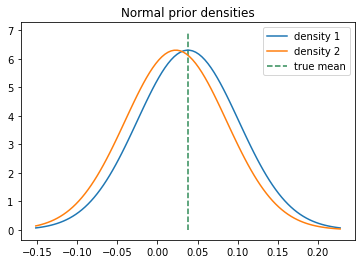

In [38]:
plot_normal_densities(
    mu1=mu1,
    var1=var1,
    mu2=mu2,
    var2=var2,
    vertical_marker=params.loc["wage_a", "exp_edu"][0],
)

In [39]:
np.random.seed(34)
start_selection = time.perf_counter()
history_selection = respyabc(
    model=models,
    parameters_prior=parameter_prior_selection,
    data=pseudo_observed_data_a,
    distance_abc=compute_mean_squared_distance,
    descriptives="choice_frequencies",
    population_size_abc=population_size,
    max_nr_populations_abc=max_nr_populations,
    minimum_epsilon_abc=minimum_epsilon,
    model_selection=True,
)
end_selection = time.perf_counter()

In [40]:
time_multi, unit_multi = convert_time(end_multi - start_multi)
f"The respyabc run for delta using choice frequencies took {time_multi:0.2f} {unit_multi}"

'The respyabc run for delta using choice frequencies took 1.10 minutes'

In [41]:
model_probabilities = history_selection.get_model_probabilities()
model_probabilities

m,0
t,
0,1.0
1,1.0


<AxesSubplot:title={'center':'Model probabilities'}, xlabel='Population index', ylabel='Probability'>

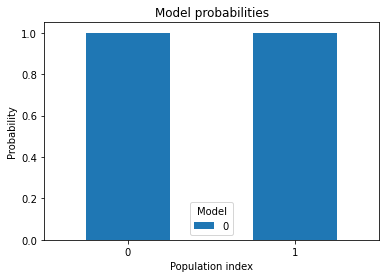

In [42]:
plot_model_probabilities(history_selection)

# 4 Concluision
---